## <b>PART 1: Collect Compound Chembl Data</b>

In [1]:
# Import necessary modules
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from collections import defaultdict
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFMCS
import pandas as pd
import numpy
from rdkit.Chem import PandasTools
IPythonConsole.ipython_useSVG=True

RDKit WARNING: [15:54:18] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from chembl_webresource_client.new_client import new_client
import pandas as pd
import math
from rdkit.Chem import PandasTools

In [3]:
targets = new_client.target
compounds = new_client.molecule
bioactivities = new_client.activity

In [4]:
uniprot_id = 'P31751'
# Get target information from ChEMBL but restrict to specified values only
target_P31751 = targets.get(target_components__accession=uniprot_id) \
                       .only('target_chembl_id', 'organism', 'pref_name', 'target_type')
print(type(target_P31751))
pd.DataFrame.from_records(target_P31751)

<class 'chembl_webresource_client.query_set.QuerySet'>


,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Serine/threonine-protein kinase AKT2,CHEMBL2431,SINGLE PROTEIN
1,Homo sapiens,Serine/threonine-protein kinase AKT2,CHEMBL2431,SINGLE PROTEIN
2,Homo sapiens,Serine/threonine-protein kinase AKT,CHEMBL2111353,PROTEIN FAMILY
3,Homo sapiens,Serine/threonine-protein kinase Rac alpha/beta,CHEMBL4106175,PROTEIN FAMILY


In [5]:
target = target_P31751[0]
target

{'organism': 'Homo sapiens',
 'pref_name': 'Serine/threonine-protein kinase AKT2',
 'target_chembl_id': 'CHEMBL2431',
 'target_type': 'SINGLE PROTEIN'}

In [6]:
chembl_id = target['target_chembl_id']
chembl_id

'CHEMBL2431'

In [7]:
bioact = bioactivities.filter(target_chembl_id = chembl_id) \
                      .filter(type = 'IC50') \
                      .filter(relation = '=') \
                      .filter(assay_type = 'B') \
                      .only('activity_id','assay_chembl_id', 'assay_description', 'assay_type', \
                            'molecule_chembl_id', 'type', 'units', 'relation', 'value', \
                            'target_chembl_id', 'target_organism')
len(bioact), len(bioact[0]), type(bioact), type(bioact[0])

(937, 11, chembl_webresource_client.query_set.QuerySet, dict)

In [8]:
bioact[0]

{'activity_id': 1429966,
 'assay_chembl_id': 'CHEMBL876978',
 'assay_description': 'Inhibitory concentration against human Protein kinase B, Akt2',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL362455',
 'relation': '=',
 'target_chembl_id': 'CHEMBL2431',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'nM',
 'value': '23000'}

In [9]:
bioact_df = pd.DataFrame.from_records(bioact)
bioact_df.head(10)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,target_chembl_id,target_organism,type,units,value
0,1429966,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL362455,=,CHEMBL2431,Homo sapiens,IC50,nM,23000
1,1429966,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL362455,=,CHEMBL2431,Homo sapiens,IC50,nM,23000
2,1429969,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL260397,=,CHEMBL2431,Homo sapiens,IC50,nM,2090
3,1429972,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL440560,=,CHEMBL2431,Homo sapiens,IC50,nM,15700
4,1430080,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL178397,=,CHEMBL2431,Homo sapiens,IC50,nM,24000
5,1430083,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL572629,=,CHEMBL2431,Homo sapiens,IC50,nM,1179
6,1430089,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL3143722,=,CHEMBL2431,Homo sapiens,IC50,nM,1755
7,1430092,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL178133,=,CHEMBL2431,Homo sapiens,IC50,nM,45270
8,1430095,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL3143723,=,CHEMBL2431,Homo sapiens,IC50,nM,5407
9,1430523,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL3143721,=,CHEMBL2431,Homo sapiens,IC50,nM,4517


In [10]:
bioact_df.shape

(938, 11)

In [11]:
bioact_df = bioact_df.dropna(axis=0, how = 'any')
bioact_df.shape

(938, 11)

In [12]:
bioact_df = bioact_df.drop_duplicates('molecule_chembl_id', keep = 'first')
bioact_df.shape

(827, 11)

In [13]:
print(bioact_df.units.unique())
bioact_df = bioact_df.drop(bioact_df.index[~bioact_df.units.str.contains('M')])
print(bioact_df.units.unique())
bioact_df.shape

['nM' 'uM']
['nM' 'uM']


(827, 11)

In [14]:
bioact_df = bioact_df.reset_index(drop=True) 
bioact_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,target_chembl_id,target_organism,type,units,value
0,1429966,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL362455,=,CHEMBL2431,Homo sapiens,IC50,nM,23000
1,1429969,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL260397,=,CHEMBL2431,Homo sapiens,IC50,nM,2090
2,1429972,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL440560,=,CHEMBL2431,Homo sapiens,IC50,nM,15700
3,1430080,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL178397,=,CHEMBL2431,Homo sapiens,IC50,nM,24000
4,1430083,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL572629,=,CHEMBL2431,Homo sapiens,IC50,nM,1179


In [15]:
def convert_to_NM(unit, bioactivity):
#     c=0
# for i, unit in enumerate(bioact_df.units):
    if unit != "nM":        
        if unit == "pM":
            value = float(bioactivity)/1000
        elif unit == "10'-11M":
            value = float(bioactivity)/100
        elif unit == "10'-10M":
            value = float(bioactivity)/10
        elif unit == "10'-8M":
            value = float(bioactivity)*10
        elif unit == "10'-1microM" or unit == "10'-7M":
            value = float(bioactivity)*100
        elif unit == "uM" or unit == "/uM" or unit == "10'-6M":
            value = float(bioactivity)*1000
        elif unit == "10'1 uM":
            value = float(bioactivity)*10000
        elif unit == "10'2 uM":
            value = float(bioactivity)*100000
        elif unit == "mM":
            value = float(bioactivity)*1000000
        elif unit == "M":
            value = float(bioactivity)*1000000000
        else:
            print ('unit not recognized...', unit)
        return value
    else: return bioactivity

In [16]:
bioactivity_nM = []
for i, row in bioact_df.iterrows():
    bioact_nM = convert_to_NM(row['units'], row['value'])
    bioactivity_nM.append(bioact_nM)
bioact_df['value'] = bioactivity_nM
bioact_df['units'] = 'nM'
bioact_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,target_chembl_id,target_organism,type,units,value
0,1429966,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL362455,=,CHEMBL2431,Homo sapiens,IC50,nM,23000
1,1429969,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL260397,=,CHEMBL2431,Homo sapiens,IC50,nM,2090
2,1429972,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL440560,=,CHEMBL2431,Homo sapiens,IC50,nM,15700
3,1430080,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL178397,=,CHEMBL2431,Homo sapiens,IC50,nM,24000
4,1430083,CHEMBL876978,Inhibitory concentration against human Protein...,B,CHEMBL572629,=,CHEMBL2431,Homo sapiens,IC50,nM,1179


In [32]:
cmpd_id_list = list(bioact_df['molecule_chembl_id'])
compound_list = compounds.filter(molecule_chembl_id__in = cmpd_id_list) \
                         .only('molecule_chembl_id', 'molecule_structures')

In [33]:
compound_df = pd.DataFrame.from_records(compound_list)
compound_df = compound_df.drop_duplicates('molecule_chembl_id', keep = 'first')
print(compound_df.shape)
print(bioact_df.shape)
compound_df.head()

(827, 2)
(827, 11)


,molecule_chembl_id,molecule_structures
0,CHEMBL104264,{'canonical_smiles': 'Brc1ccc(\C=C\CNCCNS(=O)(...
2,CHEMBL178468,{'canonical_smiles': 'CC(C)Cc1nc(c2ccccc2)c(nc...
3,CHEMBL182101,{'canonical_smiles': 'Cn1nnnc1c2cnc(c3ccc(CN4C...
4,CHEMBL178397,{'canonical_smiles': 'CC1=NC(=C(NC1=O)c2ccccc2...
5,CHEMBL362016,{'canonical_smiles': 'CC(C)Cc1nc(c2ccc(CN3CCC(...


In [34]:
for i, cmpd in compound_df.iterrows():
    if compound_df.loc[i]['molecule_structures'] != None:
        compound_df.loc[i]['molecule_structures'] = cmpd['molecule_structures']['canonical_smiles']

print (compound_df.shape)

(827, 2)


In [38]:
cmpd_phase_list = list(bioact_df['molecule_chembl_id'])
compound_phase = compounds.filter(molecule_chembl_id__in = cmpd_phase_list) \
                         .only('molecule_chembl_id', 'max_phase')

In [39]:
compound_phase_df = pd.DataFrame.from_records(compound_phase)
compound_phase_df = compound_phase_df.drop_duplicates('molecule_chembl_id', keep = 'first')
print(compound_phase_df.shape)
print(compound_df.shape)
print(bioact_df.shape)
compound_phase_df.head()

(827, 2)
(827, 2)
(827, 11)


,max_phase,molecule_chembl_id
0,0,CHEMBL104264
2,0,CHEMBL178468
3,0,CHEMBL182101
4,0,CHEMBL178397
5,0,CHEMBL362016


In [42]:
preoutput_df = pd.merge(bioact_df[['molecule_chembl_id','units','value']], compound_df, on='molecule_chembl_id')
print(preoutput_df.shape)
preoutput_df.head()

(827, 4)


,molecule_chembl_id,units,value,molecule_structures
0,CHEMBL362455,nM,23000,CC(C)(N)c1ccc(cc1)c2nc3ccccc3nc2c4ccccc4
1,CHEMBL260397,nM,2090,Oc1nc2ccccc2n1C3CCN(Cc4ccc(cc4)c5nc6ccccc6nc5c...
2,CHEMBL440560,nM,15700,O=C1NC(=C(N=C1)c2ccc(CN3CCC(CC3)N4C(=O)Nc5cccc...
3,CHEMBL178397,nM,24000,CC1=NC(=C(NC1=O)c2ccccc2)c3ccc(CN4CCC(CC4)N5C(...
4,CHEMBL572629,nM,1179,CC1=NC(=C(NC1=O)c2ccc(CN3CCC(CC3)N4C(=O)Nc5ccc...


In [43]:
output_df = pd.merge(preoutput_df, compound_phase_df, on='molecule_chembl_id')
print(output_df.shape)
output_df.head()

(827, 5)


,molecule_chembl_id,units,value,molecule_structures,max_phase
0,CHEMBL362455,nM,23000,CC(C)(N)c1ccc(cc1)c2nc3ccccc3nc2c4ccccc4,0
1,CHEMBL260397,nM,2090,Oc1nc2ccccc2n1C3CCN(Cc4ccc(cc4)c5nc6ccccc6nc5c...,0
2,CHEMBL440560,nM,15700,O=C1NC(=C(N=C1)c2ccc(CN3CCC(CC3)N4C(=O)Nc5cccc...,0
3,CHEMBL178397,nM,24000,CC1=NC(=C(NC1=O)c2ccccc2)c3ccc(CN4CCC(CC4)N5C(...,0
4,CHEMBL572629,nM,1179,CC1=NC(=C(NC1=O)c2ccc(CN3CCC(CC3)N4C(=O)Nc5ccc...,0


In [44]:
output_df = output_df.rename(columns= {'molecule_structures':'smiles', 'value':'IC50'})
output_df.shape

(827, 5)

In [45]:
output_df = output_df[~output_df['smiles'].isnull()]
print(output_df.shape)
output_df.head()

(827, 5)


,molecule_chembl_id,units,IC50,smiles,max_phase
0,CHEMBL362455,nM,23000,CC(C)(N)c1ccc(cc1)c2nc3ccccc3nc2c4ccccc4,0
1,CHEMBL260397,nM,2090,Oc1nc2ccccc2n1C3CCN(Cc4ccc(cc4)c5nc6ccccc6nc5c...,0
2,CHEMBL440560,nM,15700,O=C1NC(=C(N=C1)c2ccc(CN3CCC(CC3)N4C(=O)Nc5cccc...,0
3,CHEMBL178397,nM,24000,CC1=NC(=C(NC1=O)c2ccccc2)c3ccc(CN4CCC(CC4)N5C(...,0
4,CHEMBL572629,nM,1179,CC1=NC(=C(NC1=O)c2ccc(CN3CCC(CC3)N4C(=O)Nc5ccc...,0


In [46]:
output_df = output_df.reset_index(drop=True)
ic50 = output_df.IC50.astype(float) 
print(len(ic50))
print(ic50.head(10))

827
0    23000.0
1     2090.0
2    15700.0
3    24000.0
4     1179.0
5     1755.0
6    45270.0
7     5407.0
8     4517.0
9    18000.0
Name: IC50, dtype: float64


In [47]:
# Convert IC50 to pIC50 and add pIC50 column:
pIC50 = pd.Series() 
i = 0
while i < len(output_df.IC50):
    value = 9 - math.log10(ic50[i]) # pIC50=-log10(IC50 mol/l) --> for nM: -log10(IC50*10**-9)= 9-log10(IC50)
    if value < 0:
        print("Negative pIC50 value at index"+str(i))
    pIC50.at[i] = value
    i += 1
    
output_df['pIC50'] = pIC50
output_df.head()

,molecule_chembl_id,units,IC50,smiles,max_phase,pIC50
0,CHEMBL362455,nM,23000,CC(C)(N)c1ccc(cc1)c2nc3ccccc3nc2c4ccccc4,0,4.638272
1,CHEMBL260397,nM,2090,Oc1nc2ccccc2n1C3CCN(Cc4ccc(cc4)c5nc6ccccc6nc5c...,0,5.679854
2,CHEMBL440560,nM,15700,O=C1NC(=C(N=C1)c2ccc(CN3CCC(CC3)N4C(=O)Nc5cccc...,0,4.804100
3,CHEMBL178397,nM,24000,CC1=NC(=C(NC1=O)c2ccccc2)c3ccc(CN4CCC(CC4)N5C(...,0,4.619789
4,CHEMBL572629,nM,1179,CC1=NC(=C(NC1=O)c2ccc(CN3CCC(CC3)N4C(=O)Nc5ccc...,0,5.928486


In [48]:
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol='smiles')

In [49]:
output_df.sort_values(by="pIC50", ascending=False, inplace=True)
output_df.reset_index(drop=True, inplace=True)

,molecule_chembl_id,units,IC50,max_phase,pIC50,ROMol
0,CHEMBL3701767,nM,0.26,0,9.585027,
1,CHEMBL3701740,nM,0.27,0,9.568636,
2,CHEMBL3701766,nM,0.28,0,9.552842,
3,CHEMBL3701717,nM,0.29,0,9.537602,
4,CHEMBL3701737,nM,0.3,0,9.522879,

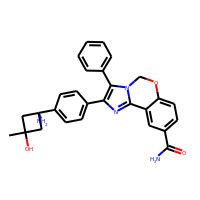
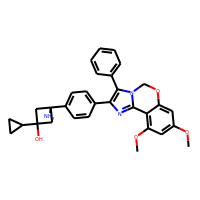
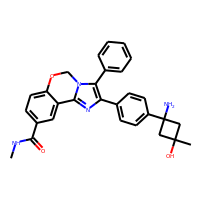
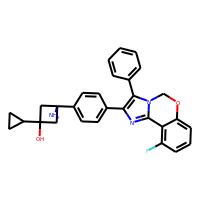
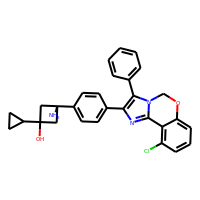

In [50]:
output_df.drop("smiles", axis=1).head()

In [51]:
output_df.drop("ROMol", axis=1).to_csv("PHASEGSKmol_compounds.csv")

## <b>PART 2: Molecular filtering: ADME and lead-likeness criteria</b>

In [52]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
from rdkit.Chem import Draw
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from math import pi

<b>Example:</b>

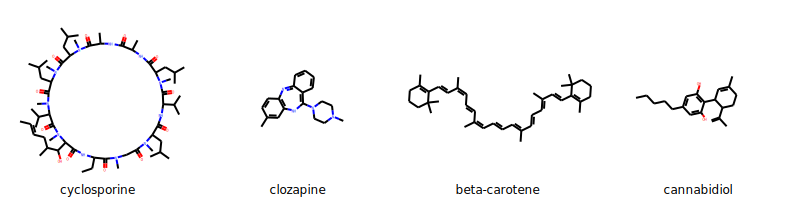

In [53]:
smiles_1 = 'CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(C(=O)NC(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N1)C(C(C)CC=CC)O)C)C(C)C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C' # Cyclosporine
smiles_2 = 'CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C' # Clozapine
smiles_3 = 'CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=C(C)C=CC2=C(CCCC2(C)C)C)C)C' # Beta-carotene
smiles_4 = 'CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O' # Cannabidiol
smiles_list = [smiles_1, smiles_2, smiles_3, smiles_4]
names_list = ['cyclosporine', 'clozapine', 'beta-carotene', 'cannabidiol']
mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

Draw.MolsToGridImage(mol_list, legends=names_list, molsPerRow=4)

In [54]:
MWs = [Descriptors.ExactMolWt(mol) for mol in mol_list]
HBAs = [Descriptors.NumHAcceptors(mol) for mol in mol_list]
HBDs = [Descriptors.NumHDonors(mol) for mol in mol_list]
LogPs = [Descriptors.MolLogP(mol) for mol in mol_list]
parameters = [MWs, HBAs, HBDs, LogPs]
print('Molecular weight of the four compounds:',MWs)

Molecular weight of the four compounds: [1201.841367992, 306.184446704, 536.438201792, 314.2245802]


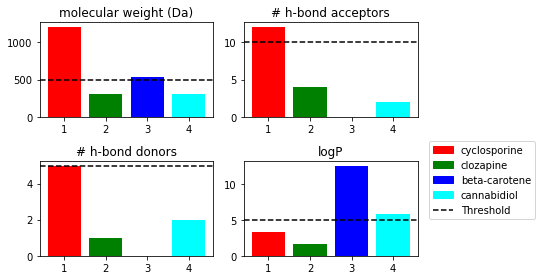

In [55]:
# Start 2x2 plot frame
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
axes = [ax1, ax2, ax3, ax4]
x = np.arange(1, len(mol_list)+1)
colors = ['red', 'green', 'blue', 'cyan']

# Create subplots
for index in x-1:
    axes[index].bar(x, parameters[index], color=colors)

# Add rule of five thresholds as dashed lines
ax1.axhline(y=500, color="black", linestyle="dashed")
ax1.set_title("molecular weight (Da)")
ax2.axhline(y=10, color="black", linestyle="dashed")
ax2.set_title("# h-bond acceptors")
ax3.axhline(y=5, color="black", linestyle="dashed")
ax3.set_title("# h-bond donors")
ax4.axhline(y=5, color="black", linestyle="dashed")
ax4.set_title("logP")

# Add legend
legend_elements = [mpatches.Patch(color=colors[i], label=names_list[i]) for i in range(len(mol_list))]
legend_elements.append(Line2D([0], [0], color="black", ls="dashed", label="Threshold"))
fig.legend(handles=legend_elements, bbox_to_anchor=(1.25, 0.5))

# Fit subplots and legend into figure
plt.tight_layout()

plt.show()

In [56]:
def test_rule_of_five(smi):
    m = Chem.MolFromSmiles(smi)
    
    # Calculate rule of five chemical properties
    MW = Descriptors.ExactMolWt(m)
    HBA = Descriptors.NumHAcceptors(m)
    HBD = Descriptors.NumHDonors(m)
    LogP = Descriptors.MolLogP(m)
    
    # Rule of five conditions
    conditions = [MW <= 500, HBA <= 10, HBD <= 5, LogP <= 5]
    # Return True if no more than one out of four conditions is violated
    return conditions.count(True) >= 3

In [57]:
for i in range(len(smiles_list)):
    smi=smiles_list[i]
    name=names_list[i]
    print("Rule of five accepted for %s: %s "%(name,test_rule_of_five(smi)))

Rule of five accepted for cyclosporine: False 
Rule of five accepted for clozapine: True 
Rule of five accepted for beta-carotene: False 
Rule of five accepted for cannabidiol: True 


<b>Example Finished</b>

In [58]:
def df_rule_of_five(df):
    
    smi = df['smiles']
    m = Chem.MolFromSmiles(smi)
    
    # Calculate rule of five chemical properties
    MW = Descriptors.ExactMolWt(m)
    HBA = Descriptors.NumHAcceptors(m)
    HBD = Descriptors.NumHDonors(m)
    LogP = Descriptors.MolLogP(m)
    
    # Rule of five conditions
    conditions = [MW <= 500, HBA <= 10, HBD <= 5, LogP <= 5]
    
    # Create pandas row for conditions results with values and information whether rule of five is violated
    return pd.Series([MW, HBA, HBD, LogP, 'yes']) if conditions.count(True) >= 3 else pd.Series([MW, HBA, HBD, LogP, 'no'])

In [59]:
ChEMBL_df = pd.read_csv('PHASEGSKmol_compounds.csv', index_col=0)
print(ChEMBL_df.shape)
ChEMBL_df.head()

(827, 6)


,molecule_chembl_id,units,IC50,smiles,max_phase,pIC50
0,CHEMBL3701767,nM,0.26,CC1(O)CC(N)(C1)c2ccc(cc2)c3nc4c5cc(ccc5OCn4c3c...,0,9.585027
1,CHEMBL3701740,nM,0.27,COc1cc(OC)c2c(OCn3c2nc(c4ccc(cc4)C5(N)CC(O)(C5...,0,9.568636
2,CHEMBL3701766,nM,0.28,CNC(=O)c1ccc2OCn3c(nc(c4ccc(cc4)C5(N)CC(C)(O)C...,0,9.552842
3,CHEMBL3701717,nM,0.29,NC1(CC(O)(C1)C2CC2)c3ccc(cc3)c4nc5c6c(F)cccc6O...,0,9.537602
4,CHEMBL3701737,nM,0.30,NC1(CC(O)(C1)C2CC2)c3ccc(cc3)c4nc5c6c(Cl)cccc6...,0,9.522879


In [60]:
# Apply ruleOfFive to dataset to get rule of five results (may take a while)
rule5_prop_df = ChEMBL_df.apply(df_rule_of_five, axis=1)

# Name condition columns
rule5_prop_df.columns= ['MW', 'HBA', 'HBD', 'LogP', 'rule_of_five_conform']

In [61]:
# Concatenate dataset with computed values
ChEMBL_df = ChEMBL_df.join(rule5_prop_df)

In [62]:
# Delete empty rows --> rule of five
filtered_df = ChEMBL_df[ChEMBL_df['rule_of_five_conform']=='yes']

In [63]:
# Info about data
print('# of compounds in unfiltered data set:', len(ChEMBL_df))
print('# of compounds in filtered data set:', len(filtered_df))
print("# of compounds not compliant with Lipinski's rule of five:", (len(ChEMBL_df)-len(filtered_df)))

# Save filtered data 
filtered_df.to_csv('PHASEGSKmol_compounds_lipinski.csv', sep=';') 
filtered_df.head(10)

# of compounds in unfiltered data set: 827
# of compounds in filtered data set: 635
# of compounds not compliant with Lipinski's rule of five: 192


,molecule_chembl_id,units,IC50,smiles,max_phase,pIC50,MW,HBA,HBD,LogP,rule_of_five_conform
0,CHEMBL3701767,nM,0.26,CC1(O)CC(N)(C1)c2ccc(cc2)c3nc4c5cc(ccc5OCn4c3c...,0,9.585027,466.200491,6,3,4.0317,yes
2,CHEMBL3701766,nM,0.28,CNC(=O)c1ccc2OCn3c(nc(c4ccc(cc4)C5(N)CC(C)(O)C...,0,9.552842,480.216141,6,3,4.2924,yes
3,CHEMBL3701717,nM,0.29,NC1(CC(O)(C1)C2CC2)c3ccc(cc3)c4nc5c6c(F)cccc6O...,0,9.537602,467.200905,5,2,5.4620,yes
4,CHEMBL3701737,nM,0.30,NC1(CC(O)(C1)C2CC2)c3ccc(cc3)c4nc5c6c(Cl)cccc6...,0,9.522879,483.171355,5,2,5.9763,yes
5,CHEMBL3701769,nM,0.31,CCNC(=O)c1ccc2OCn3c(nc(c4ccc(cc4)C5(N)CC(C)(O)...,0,9.508638,494.231791,6,3,4.6825,yes
6,CHEMBL3701762,nM,0.32,CC1(O)CC(N)(C1)c2ccc(cc2)c3nc4c5cc(ccc5OCn4c3c...,0,9.494850,489.216475,6,3,5.3229,yes
7,CHEMBL3701776,nM,0.40,CC1(O)CC(N)(C1)c2ccc(cc2)c3nc4c5ccc(cc5OCn4c3c...,0,9.397940,466.200491,6,3,4.0317,yes
8,CHEMBL3701775,nM,0.40,CCONC(=O)c1ccc2OCn3c(nc(c4ccc(cc4)C5(N)CC(C)(O...,0,9.397940,510.226705,7,3,4.6141,yes
9,CHEMBL3701763,nM,0.42,CC1(O)CC(N)(C1)c2ccc(cc2)c3nc4c5cc(ccc5OCn4c3c...,0,9.376751,489.216475,6,3,5.3229,yes
10,CHEMBL3701749,nM,0.48,NC1(CC(O)(C1)C2CC2)c3ccc(cc3)c4nc5c6ccncc6OCn5...,0,9.318759,450.205576,6,2,4.7179,yes


In [64]:
def get_properties_stats(data_df):
    """
    Function that calculates the mean and standard deviation of physicochemical properties of a dataset.
    
    Input: 
    Dataset containing per compound values for physicochemical properties
    HBD, HBA, MW and LogP as columns (with exactly these names).
    
    Output:
    Dataframe with mean and std (columns) for each physicochemical property (rows).
    """
    properties = ["HBD", "HBA", "MW", "LogP"]
    
    data_stats = []
    
    for i in properties:
        std = data_df[i].std()
        mean = data_df[i].mean()
        da = pd.DataFrame([[round(mean, 2), round(std, 2)]], index=[i], columns=["mean", "std"])
        data_stats.append(da)
    
    data_stats = pd.concat(data_stats)
    
    return data_stats

In [65]:
stats_rof = get_properties_stats(filtered_df)
stats_rof

,mean,std
HBD,2.09,1.06
HBA,5.28,1.87
MW,417.07,71.61
LogP,4.06,1.49


In [66]:
stats_not_rof = get_properties_stats(ChEMBL_df[ChEMBL_df['rule_of_five_conform']=='no'])
stats_not_rof

,mean,std
HBD,1.54,0.77
HBA,7.84,1.70
MW,571.13,50.39
LogP,5.78,0.75


In [67]:
def plot_radarplot(data_stats, output_path):
    """
    Function that plots a radar plot based on the mean and std of 4 physicochemical properties (HBD, HBA, MW and LogP).
    
    Input: 
    Dataframe with mean and std (columns) for each physicochemical property (rows).
    
    Output:
    Radar plot (saved as file and shown in Jupyter notebook).
    """

    # Get data points for lines
    std_1 = [data_stats["mean"]["HBD"] + data_stats["std"]["HBD"], 
             (data_stats["mean"]["HBA"]/2) + (data_stats["std"]["HBA"]/2), 
             (data_stats["mean"]["MW"]/100) + (data_stats["std"]["MW"]/100), 
             data_stats["mean"]["LogP"] + data_stats["std"]["LogP"]]
    std_2 = [data_stats["mean"]["HBD"] - data_stats["std"]["HBD"], 
             (data_stats["mean"]["HBA"]/2) - (data_stats["std"]["HBA"]/2), 
             (data_stats["mean"]["MW"]/100) - (data_stats["std"]["MW"]/100), 
             data_stats["mean"]["LogP"] - data_stats["std"]["LogP"]]
    mean_val = [data_stats["mean"]["HBD"], (data_stats["mean"]["HBA"]/2), 
                (data_stats["mean"]["MW"]/100), data_stats["mean"]["LogP"]]

    # Get data points for (filled) area (rule of five)
    rule_conditions = [5, (10/2), (500/100), 5]
    
    # Define property names
    parameters = ['# H-bond donors', '# H-bond acceptors/2', 'Molecular weight (Da)/100', 'LogP']

    # 
    N = len(rule_conditions)

    # Set font size
    fontsize = 16

    # Angles for the condition axes
    x_as = [n / float(N) * 2 * pi for n in range(N)]

    # Since our chart will be circular we need to append a copy of the first
    # Value of each list at the end of each list with data
    std_1 += std_1[:1]
    std_2 += std_2[:1]
    mean_val += mean_val[:1]
    rule_conditions += rule_conditions[:1]
    x_as += x_as[:1]

    # Set figure size
    plt.figure(figsize=(8,8))

    # Set color of axes
    plt.rc('axes', linewidth=2, edgecolor="#888888")

    # Create polar plot
    ax = plt.subplot(111, polar=True)

    # Set clockwise rotation. That is:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Set position of y-labels
    ax.set_rlabel_position(0)

    # Set color and linestyle of grid
    ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=2)
    ax.yaxis.grid(True, color="#888888", linestyle='solid', linewidth=2)

    # Set number of radial axes and remove labels
    plt.xticks(x_as[:-1], [])

    # Set yticks
    plt.yticks([1, 3, 5, 7], ["1", "3", "5"], size=fontsize)

    # Set axes limits
    plt.ylim(0, 7)

    # Plot data
    # Mean values
    ax.plot(x_as, mean_val, 'b', linewidth=3, linestyle='solid', zorder=3)

    # Standard deviation
    ax.plot(x_as, std_1, 'm', linewidth=2, linestyle='dashed', zorder=3, color='#111111')
    ax.plot(x_as, std_2, 'y', linewidth=2, linestyle='dashed', zorder=3, color='#333333')

    # Fill area
    ax.fill(x_as, rule_conditions, "#3465a4", alpha=0.2)

    # Draw ytick labels to make sure they fit properly
    for i in range(N):
        angle_rad = i / float(N) * 2 * pi
        if angle_rad == 0:
            ha, distance_ax = "center", 1
        elif 0 < angle_rad < pi:
            ha, distance_ax = "left", 1
        elif angle_rad == pi:
            ha, distance_ax = "center", 1
        else:
            ha, distance_ax = "right", 1
        ax.text(angle_rad, 7 + distance_ax, parameters[i], size=fontsize,
                horizontalalignment=ha, verticalalignment="center")

    # Add legend relative to top-left plot    
        labels = ('Mean', 'Mean + std', 'Mean - std', 'Rule of five area')
        legend = ax.legend(labels, loc=(1.1, .7),
                           labelspacing=0.3, fontsize=fontsize)
    plt.tight_layout()

    # Save plot - use bbox_inches to include text boxes:
    # https://stackoverflow.com/questions/44642082/text-or-legend-cut-from-matplotlib-figure-on-savefig?rq=1
    plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    # Show polar plot
    plt.show()

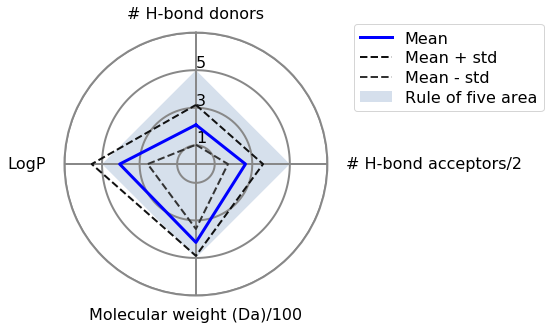

In [68]:
plot_radarplot(stats_rof, "PHASEGSKmol_radarplot_rof.png")

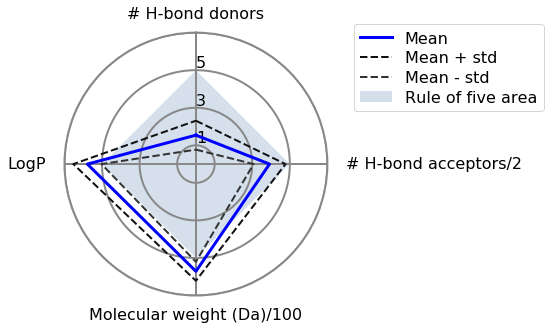

In [69]:
plot_radarplot(stats_not_rof, "PHASEGSKmol_radarplot_not_rof.png")

## <b>PART 3: Substructure filtering</b>

In [47]:
import pandas
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFMCS
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt

In [48]:
filteredData = pandas.read_csv("GSKmol_compounds_lipinski.csv", delimiter=";", index_col=0)
filteredData.drop(['HBD','HBA','MW','LogP'], inplace=True, axis=1) # Drop unnecessary information
print ('Dataframe shape: ', filteredData.shape) # Print dimension of the dataframe
filteredData.head(5)

Dataframe shape:  (635, 6)


,molecule_chembl_id,units,IC50,smiles,pIC50,rule_of_five_conform
0,CHEMBL3701767,nM,0.26,CC1(O)CC(N)(C1)c2ccc(cc2)c3nc4c5cc(ccc5OCn4c3c...,9.585027,yes
2,CHEMBL3701766,nM,0.28,CNC(=O)c1ccc2OCn3c(nc(c4ccc(cc4)C5(N)CC(C)(O)C...,9.552842,yes
3,CHEMBL3701717,nM,0.29,NC1(CC(O)(C1)C2CC2)c3ccc(cc3)c4nc5c6c(F)cccc6O...,9.537602,yes
4,CHEMBL3701737,nM,0.30,NC1(CC(O)(C1)C2CC2)c3ccc(cc3)c4nc5c6c(Cl)cccc6...,9.522879,yes
5,CHEMBL3701769,nM,0.31,CCNC(=O)c1ccc2OCn3c(nc(c4ccc(cc4)C5(N)CC(C)(O)...,9.508638,yes


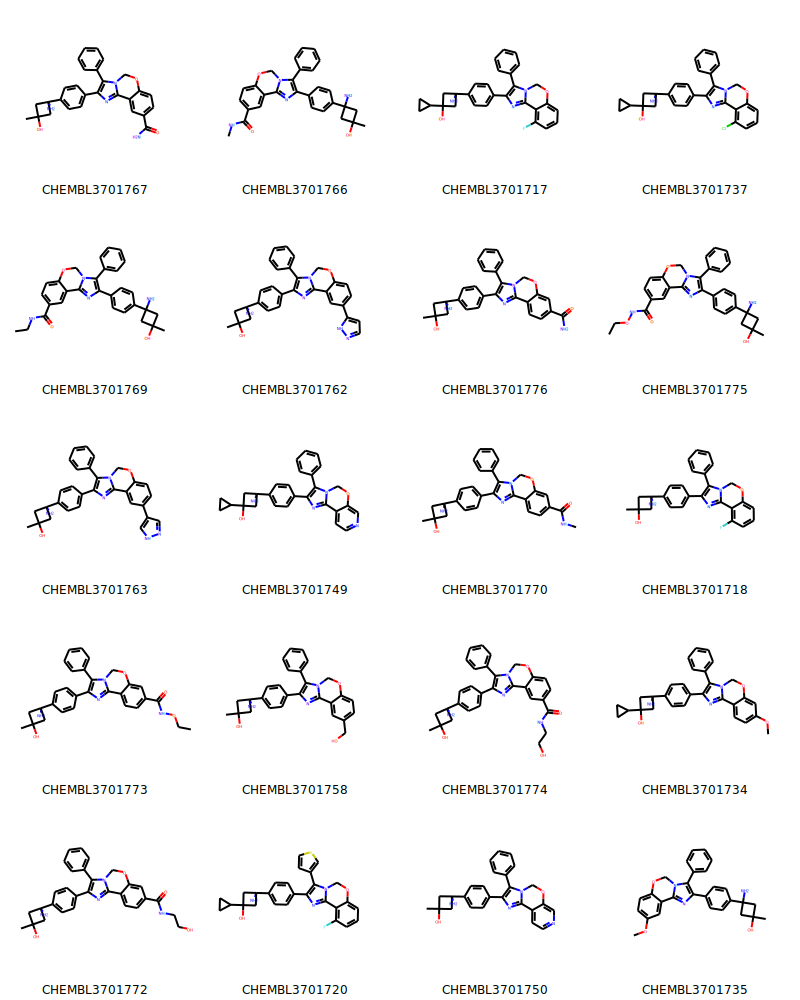

In [49]:
PandasTools.AddMoleculeColumnToFrame(filteredData, smilesCol='smiles') # Add molecule column
# Draw first 20 molecules
Draw.MolsToGridImage(list(filteredData.ROMol[0:20]), 
                    legends=list(filteredData.molecule_chembl_id[0:20]), 
                    molsPerRow=4)

In [66]:
from rdkit.Chem.FilterCatalog import *
params = FilterCatalogParams()
# Build a catalog from all PAINS (A, B and C)
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

Number of compounds with PAINS: 5
Number of compounds without PAINS: 630 (=remaining compounds)


,CompID,CompMol,unwantedID
0,CHEMBL594072,,Indol_3yl_alk(461)
1,CHEMBL574646,,Ene_one_ene_a(57)
2,CHEMBL379849,,Ene_one_ene_a(57)
3,CHEMBL2338333,,Ene_one_ene_a(57)
4,CHEMBL2036343,,Ene_one_ene_a(57)

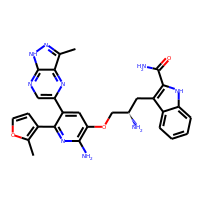
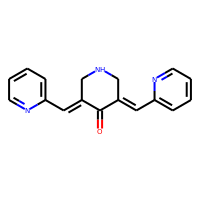
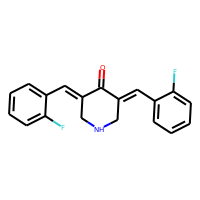
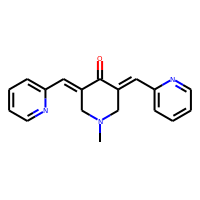
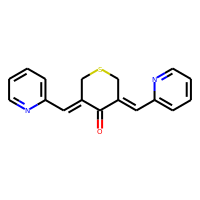

In [67]:
# Create empty dataframes for filtered data
rdkit_highLightFramePAINS = pandas.DataFrame(columns=('CompID', 'CompMol', 'unwantedID'))
rdkit_noPAINS = pandas.DataFrame(columns=('ChEMBL_ID', 'smiles','pIC50'))
rdkit_withPAINS = pandas.DataFrame(columns=('ChEMBL_ID', 'smiles', 'pIC50','unwantedID'))

# For index and row in the filtered df
for i,row in filteredData.iterrows():
    curMol = Chem.MolFromSmiles(row.smiles) # Current molecule
    match = False # Set match to false
    rdkit_PAINSList = []
    # Get the first match
    entry = catalog.GetFirstMatch(curMol)
    
    if entry!=None:
        # Add name of current unwanted subsftructure to list
        rdkit_PAINSList.append(entry.GetDescription().capitalize())
        # Add relevant matching information to dataframe
        rdkit_highLightFramePAINS.loc[len(rdkit_highLightFramePAINS)] = [row.molecule_chembl_id, curMol,
        entry.GetDescription().capitalize()]
        match = True
    if not match:
        # Add to frame of PAINS free compounds
        rdkit_noPAINS.loc[len(rdkit_noPAINS)] = [row.molecule_chembl_id, row.smiles, row.pIC50]
    else: 
        # Add to frame of compounds that contain PAINS
        # Put the relevant information in the dataframe with the unwanted substructures
        rdkit_withPAINS.loc[len(rdkit_withPAINS)] = [row.molecule_chembl_id, row.smiles, row.pIC50, entry.GetDescription().capitalize()]

print("Number of compounds with PAINS: %i"%(len(rdkit_withPAINS)))
print("Number of compounds without PAINS: %i (=remaining compounds)"%(len(rdkit_noPAINS)))

rdkit_highLightFramePAINS.head(10)

In [68]:
unwantedSubs = []
unwantedNames = []

for line in open('Data/unwantedSubstructures.csv', 'r'):
    if not line.startswith("#"): # Ignore header
        splitted = line.strip().split(" ") # Split each line
        m = Chem.MolFromSmarts(splitted[1]) # Generate a molecule from smarts
        name = splitted[0].capitalize() # Store the name in name
        unwantedNames.append(name) # Append the names of the unwanted substructes to a list
        unwantedSubs.append(m) # Append the unwanted substructes to a list
print("Number of unwanted substructures in list =", len(unwantedSubs)) # Show the number of unwanted substructures

Number of unwanted substructures in list = 104


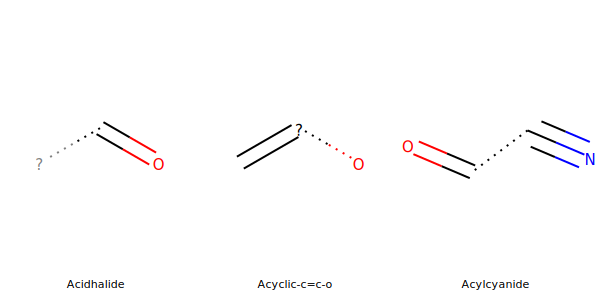

In [69]:
Chem.Draw.MolsToGridImage(list(unwantedSubs[2:5]), subImgSize=(200, 300), legends=unwantedNames[2:5])

In [70]:
# Creating dataFrames for filtered data
highLightFrameUNW = pandas.DataFrame(columns=('CompID', 'CompMol', 'unwantedID', 'unwSubstr'))
noUnwanted = pandas.DataFrame(columns=('ChEMBL_ID', 'smiles','pIC50'))
withUnwanted = pandas.DataFrame(columns=('ChEMBL_ID', 'smiles', 'pIC50','unwantedID'))
molsToDraw = []

# For each compound in data set
for i,row in filteredData.iterrows(): # For index and row in the filtered dataframe
    curMol = Chem.MolFromSmiles(row.smiles) # Current molecule
    match = False # Set match to false
    unwantedList = []
    molsToDraw.append(curMol)
    
    # Search for all unwanted substructures
    for idx, unwSub in enumerate(unwantedSubs):
        # Check if it has the substructure
        if curMol.HasSubstructMatch(unwSub): # If the current molecule has the unwanted substructure
            match = True # Set match to True
            unwantedList.append(unwantedNames[idx]) # Add name of unwanted substructure to list
            # Put the relevant information in the dataframe
            highLightFrameUNW.loc[len(highLightFrameUNW)] = [row.molecule_chembl_id, curMol, unwantedNames[idx], unwSub]
    if not match: # If no match was found
        noUnwanted.loc[len(noUnwanted)] = [row.molecule_chembl_id, row.smiles, row.pIC50]
        # Add relevant information to dataframe of the wanted substructes
    else: # If a match was found
        withUnwanted.loc[len(withUnwanted)] = [row.molecule_chembl_id, row.smiles, row.pIC50, unwantedList] #put the relevant information in the dataframe with the unwanted substructures

print("Number of compounds with unwanted substructures: %i"%(len(withUnwanted)))
print("Number of compounds without unwanted substructures: %i (=remaining compounds)"%(len(noUnwanted)))

Number of compounds with unwanted substructures: 107
Number of compounds without unwanted substructures: 528 (=remaining compounds)


,CompID,CompMol,unwantedID,unwSubstr
0,CHEMBL3701775,,Oxygen-nitrogen-single-bond,
1,CHEMBL3701773,,Oxygen-nitrogen-single-bond,
2,CHEMBL228867,,Michael-acceptor,
3,CHEMBL228652,,Michael-acceptor,

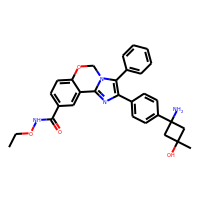
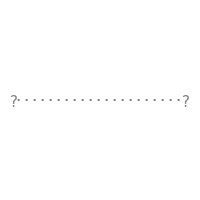
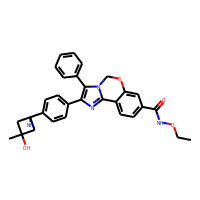
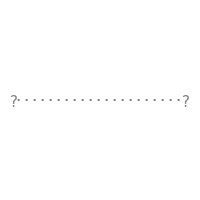
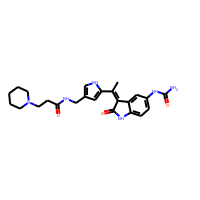
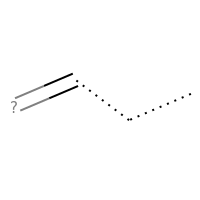
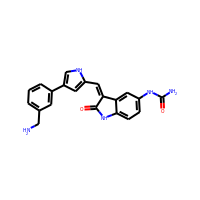
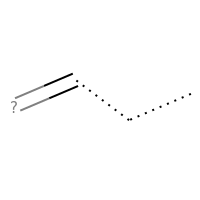

In [71]:
highLightFrameUNW.head(4)

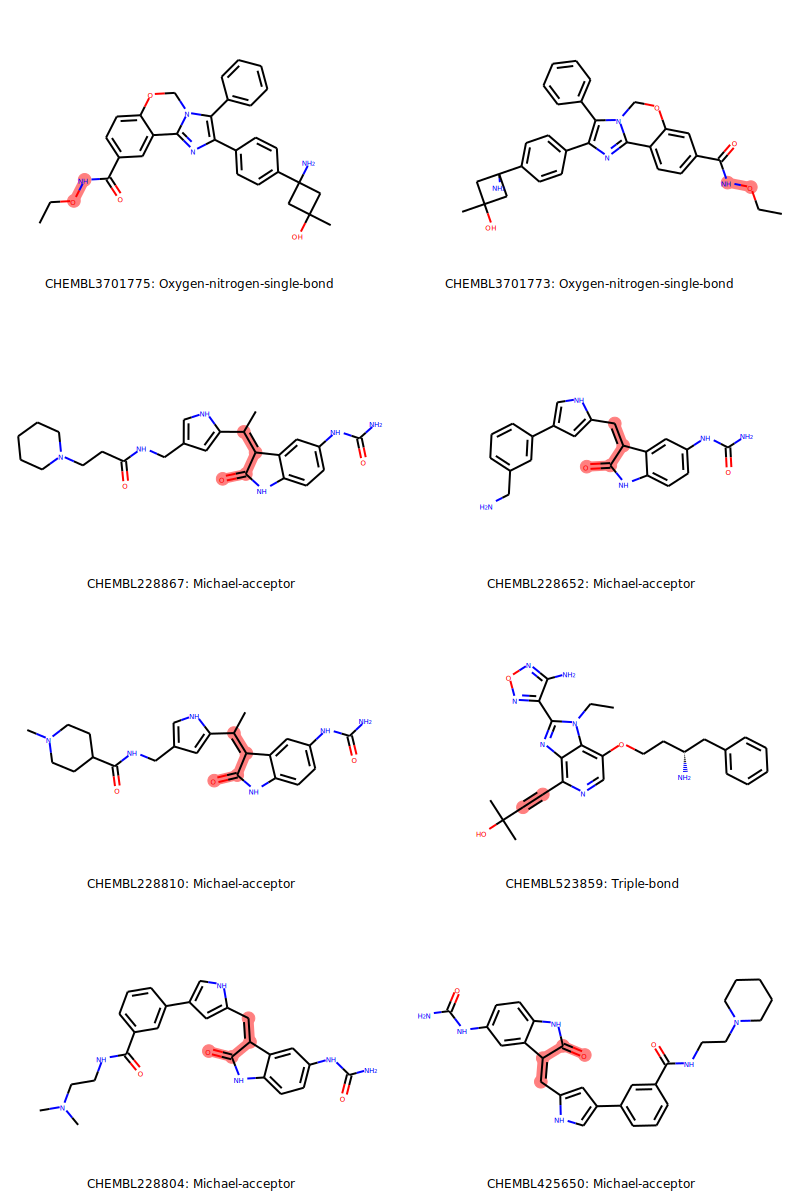

In [72]:
first_highLightFrameUNW = highLightFrameUNW.head(8) # Subset of the first 8 entries in the list

# Draw molecules and highlight the unwanted substructure 
Draw.MolsToGridImage(list(first_highLightFrameUNW["CompMol"]), subImgSize=(400,300),
    molsPerRow=2, highlightAtomLists=
    [m.GetSubstructMatch(first_highLightFrameUNW["unwSubstr"][i]) for i,m in enumerate(first_highLightFrameUNW["CompMol"])], 
    legends=list(first_highLightFrameUNW["CompID"]+": "+first_highLightFrameUNW["unwantedID"]))

In [73]:
# Save image to file
img = Draw.MolsToGridImage(list(first_highLightFrameUNW["CompMol"]), subImgSize=(400,300),
    molsPerRow=3, highlightAtomLists=
    [m.GetSubstructMatch(first_highLightFrameUNW["unwSubstr"][i]) for i,m in enumerate(first_highLightFrameUNW["CompMol"])], 
    legends=list(first_highLightFrameUNW["unwantedID"]), useSVG=True)

# Get SVG data
molsvg = img.data

# Replace non-transparent to transparent background
molsvg = molsvg.replace("opacity:1.0", "opacity:0.0");
molsvg = molsvg.replace("12px", "24px");

# Save altered SVG data to file
f = open("substructures.svg", "w")
f.write(molsvg)
f.close()

In [74]:
# Write the compounds with unwanted substructures in a csv file
withUnwanted.to_csv("GSKmol_compounds_lipinski_noPAINS.csv", sep=',') 

# Write the compounds without unwanted substructures in a csv file
noUnwanted.to_csv("GSKmol_compounds_lipinski_noPAINS_noBrenk.csv", sep=',') 

# Show the head of the csv file with the compounds with the unwanted substructures i a csv file
noUnwanted.head()

,ChEMBL_ID,smiles,pIC50
0,CHEMBL3701767,CC1(O)CC(N)(C1)c2ccc(cc2)c3nc4c5cc(ccc5OCn4c3c...,9.585027
1,CHEMBL3701766,CNC(=O)c1ccc2OCn3c(nc(c4ccc(cc4)C5(N)CC(C)(O)C...,9.552842
2,CHEMBL3701717,NC1(CC(O)(C1)C2CC2)c3ccc(cc3)c4nc5c6c(F)cccc6O...,9.537602
3,CHEMBL3701737,NC1(CC(O)(C1)C2CC2)c3ccc(cc3)c4nc5c6c(Cl)cccc6...,9.522879
4,CHEMBL3701769,CCNC(=O)c1ccc2OCn3c(nc(c4ccc(cc4)C5(N)CC(C)(O)...,9.508638


In [75]:
# Count the most frequent compounds
unwCounts = {}
for ele in highLightFrameUNW.values:
    unw = ele[2] # ID of the unwanted substructure from the dataframe highLightFrameUNW
    if unwCounts.get(unw, "empty") == "empty": # If the ID of the unwanted structure is not yet in the dictionary
        unwCounts[unw] = [1, ele[3]] # Put a 1 and the unwanted structure in the dictionary
    else: # If the key (unwanted structure ID) already exists, increment the value of occurences 
        unwCounts[unw][0] += 1

frequentUNW = []
frequentUNWNames = []

# Structure of unwCounts: Dictionary with the ID as key, and the number of occurences and molecule as values
# E.g. ('acyclic-C=C-O', [7, <rdkit.Chem.rdchem.Mol object at 0x7fa58fc06710>])

# Sort the dictionary by frequencies of substructures
for key, value in sorted(unwCounts.items(), key=lambda kv: kv[1][0], reverse=True):
    frequentUNW.append(value[1]) # Substructure
    frequentUNWNames.append(key)

In [79]:
# Eight most frequent substructeres
Draw.MolsToGridImage(mols=list(frequentUNW[0:8]),
                     legends=list(frequentUNWNames[0:8]),
                     molsPerRow=1)

RuntimeError: Pre-condition Violation
	getExplicitValence() called without call to calcExplicitValence()
	Violation occurred on line 190 in file Code/GraphMol/Atom.cpp
	Failed Expression: d_explicitValence > -1
	RDKIT: 2019.09.3
	BOOST: 1_70
